1. Setup

In [2]:
%pip install pandas numpy scikit-learn xgboost matplotlib seaborn joblib shap pyarrow


Note: you may need to restart the kernel to use updated packages.


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../../data/raw/air_12318.csv", on_bad_lines='skip')

df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')
# Load CSV, convert time column to datetime and sort rows. This ensures rolling windows
# and time-based splits operate correctly.



In [3]:
print(df.columns.tolist())
# Print the dataset columns so we can check what sensors/fields are available


['id', 'time', 'epoch', 'air', 'device', 'mVa_V', 'mVb_V', 'mVc_v', 'mVa-mBb_V', 'mVb-mVc_V', 'mVc-mVa_V', 'va_V', 'vb_V', 'vc_V', 'va-vb_V', 'vb-vc_V', 'vc-va_V', 'ia_A', 'ib_A', 'ic_A', 'pa_W', 'pb_W', 'pc_W', 'qa_Var', 'qb_Var', 'qc_Var', 'sa_VA', 'sb_VA', 'sc_VA', 'ptot_W', 'qtot_Var', 'stot_VA', 'pfa_None', 'pfb_None', 'pfc_None', 'pftot_None', 'expwh_Kwh*10', 'expvar_Kvarh*10', 'freq_Hz*10', 'temp_Degrees Celsius', 'pressure_Bar', 'fuel_%', 'vbat_V', 'hours_sec']


In [4]:
print(df.shape)
print(df.head())
# Show dataset size and a quick sample of the data

(510797, 44)
        id                      time       epoch    air  device  mVa_V  mVb_V  \
5  2258572 2023-02-24 08:56:14+00:00  1677228974  12318       1      0    0.0   
6  2271340 2023-02-28 11:05:31+00:00  1677582331  12318       1    231    NaN   
7  2271341 2023-02-28 11:05:41+00:00  1677582341  12318       1    232    NaN   
8  2271342 2023-02-28 11:05:51+00:00  1677582351  12318       1    232    NaN   
9  2271345 2023-02-28 11:06:01+00:00  1677582361  12318       1    232    NaN   

   mVc_v  mVa-mBb_V  mVb-mVc_V  ...  pfc_None  pftot_None  expwh_Kwh*10  \
5    0.0        0.0        0.0  ...       0.0         0.0           0.0   
6    NaN        NaN        NaN  ...       NaN         NaN           NaN   
7    NaN        NaN        NaN  ...       NaN         NaN           NaN   
8    NaN        NaN        NaN  ...       NaN         NaN           NaN   
9    NaN        NaN        NaN  ...       NaN         NaN           NaN   

   expvar_Kvarh*10  freq_Hz*10  temp_Degrees Cels

2. Basic Exploration (EDA)

In [5]:
print(df.describe())
# Descriptive statistics help identify skew, outliers, and the typical ranges of sensors


                 id         epoch       air    device          mVa_V  \
count  5.107970e+05  5.107970e+05  510797.0  510797.0  510797.000000   
mean   1.025530e+07  1.722158e+09   12318.0       1.0      24.724227   
std    5.015867e+06  2.120067e+07       0.0       0.0      73.156395   
min    1.700000e+01  1.677229e+09   12318.0       1.0       0.000000   
25%    6.381579e+06  1.708735e+09   12318.0       1.0       0.000000   
50%    9.953322e+06  1.724083e+09   12318.0       1.0       0.000000   
75%    1.429909e+07  1.739542e+09   12318.0       1.0       0.000000   
max    1.984786e+07  1.754950e+09   12318.0       1.0     255.000000   

               mVb_V          mVc_v      mVa-mBb_V      mVb-mVc_V  \
count  510775.000000  510775.000000  510775.000000  510775.000000   
mean       24.905581      24.976992      42.792566      43.220571   
std        73.705248      73.916944     126.643959     127.906630   
min         0.000000       0.000000       0.000000       0.000000   
25%   

In [6]:
print(df.isna().sum())
# Check missing values; small counts can be forward/backfilled, but gaps in time index may require resampling


id                       0
time                     0
epoch                    0
air                      0
device                   0
mVa_V                    0
mVb_V                   22
mVc_v                   22
mVa-mBb_V               22
mVb-mVc_V               22
mVc-mVa_V               22
va_V                    22
vb_V                    22
vc_V                    22
va-vb_V                 22
vb-vc_V                 22
vc-va_V                 22
ia_A                    22
ib_A                    22
ic_A                    22
pa_W                    22
pb_W                    22
pc_W                    22
qa_Var                  22
qb_Var                  22
qc_Var                  22
sa_VA                   22
sb_VA                   22
sc_VA                   22
ptot_W                  22
qtot_Var                22
stot_VA                 22
pfa_None                22
pfb_None                22
pfc_None                22
pftot_None              22
expwh_Kwh*10            22
e

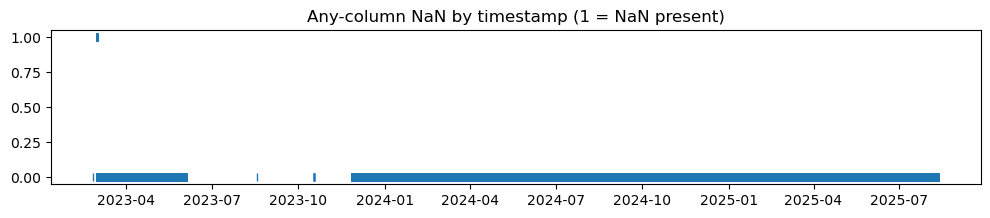

In [7]:
# show where time gaps or NaNs occur
plt.figure(figsize=(12,2))
plt.plot(df['time'], df.isna().any(axis=1).astype(int), '|')
plt.title("Any-column NaN by timestamp (1 = NaN present)")
plt.show()

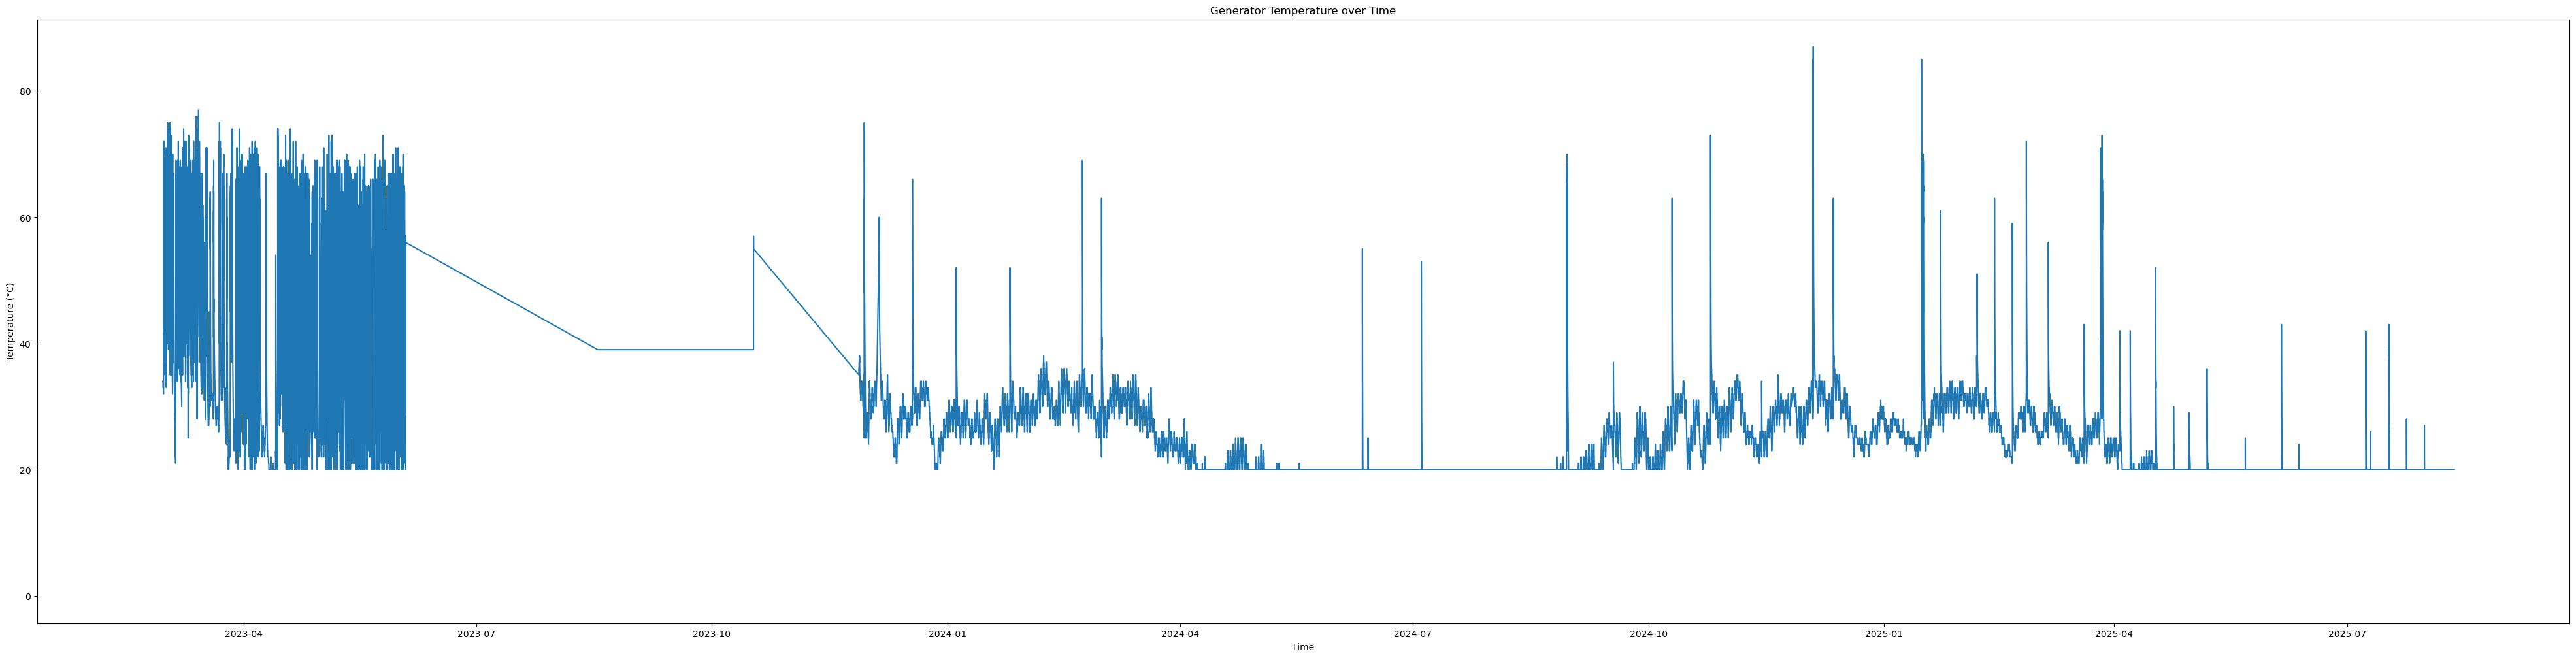

In [8]:
# Plot key signals over time
plt.figure(figsize=(50,12))
plt.plot(df['time'], df['temp_Degrees Celsius'])
plt.title("Generator Temperature over Time")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.show()
# Temperature vs time — look for steady increases, spikes, or flat/stuck sensors


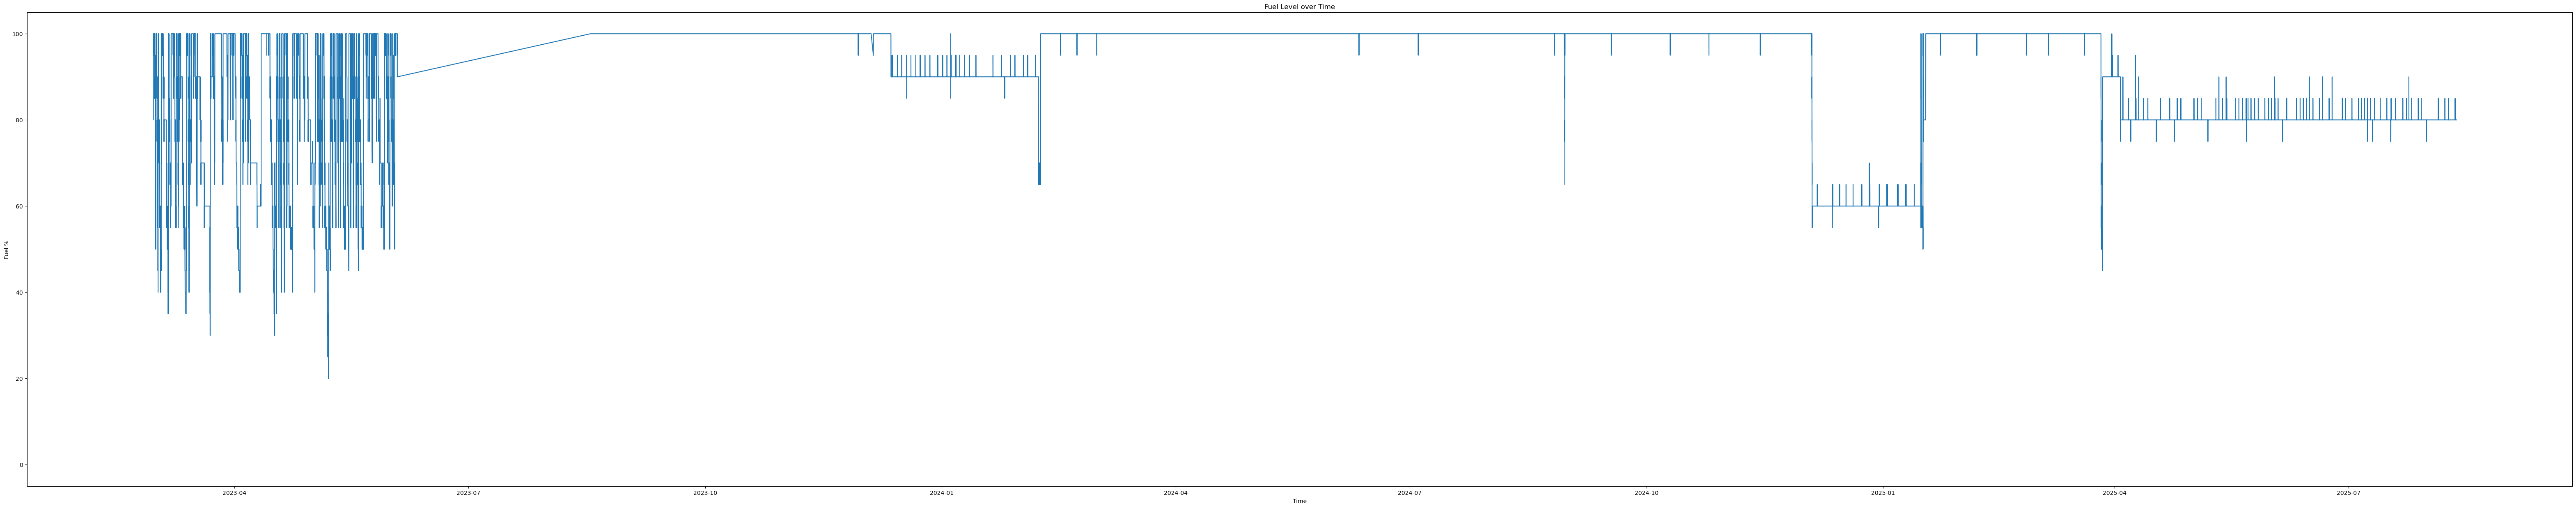

In [9]:
plt.figure(figsize=(80,15))
plt.plot(df['time'], df['fuel_%'])
plt.title("Fuel Level over Time")
plt.xlabel("Time")
plt.ylabel("Fuel %")
plt.show()
# Fuel level over time. Watch for steady declines (normal consumption), sudden jumps (refuels),
# or abrupt drops (possible sensor/measurement issues).


In [10]:
print(df['ia_A'].describe())
# Summary of phase-A current. Median=0 indicates long idle periods; ON cycles are rare but with high peaks.


count    510775.000000
mean          6.352668
std          20.466826
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         204.000000
Name: ia_A, dtype: float64


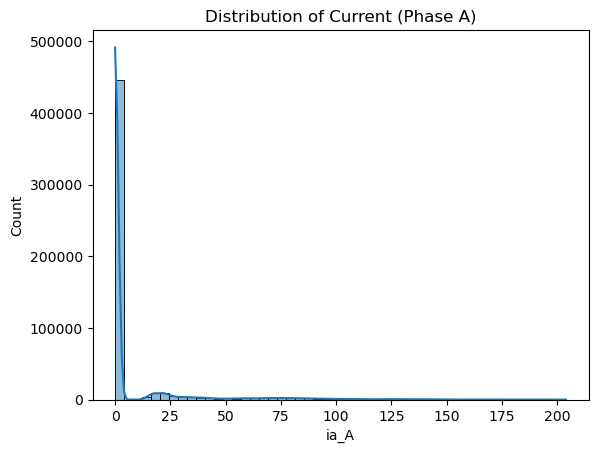

In [11]:
# Histogram of currents
sns.histplot(df['ia_A'], bins=50, kde=True)
plt.title("Distribution of Current (Phase A)")
plt.show()
# Plot histogram of Phase A current to check how often generator is drawing load
# Large number of 0s indicates long OFF cycles

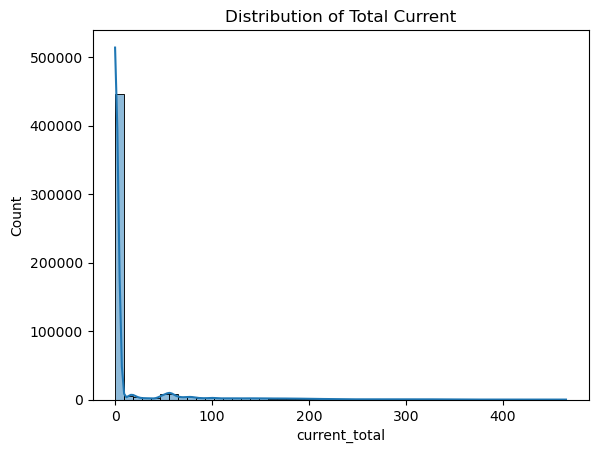

In [12]:
df['current_total'] = df[['ia_A','ib_A','ic_A']].sum(axis=1)
sns.histplot(df['current_total'], bins=50, kde=True)
plt.title("Distribution of Total Current")
plt.show()
# Compute and visualize total current across phases to inspect total load shape


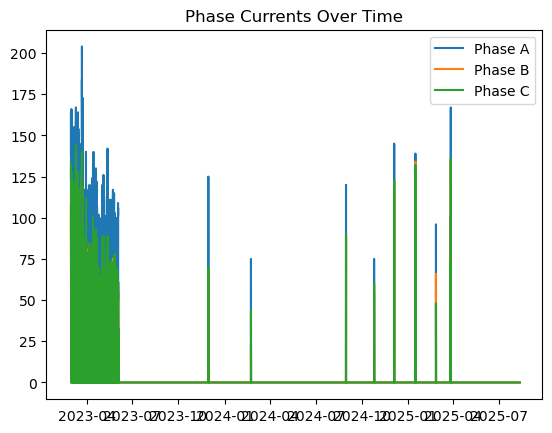

In [13]:
plt.plot(df['time'], df['ia_A'], label='Phase A')
plt.plot(df['time'], df['ib_A'], label='Phase B')
plt.plot(df['time'], df['ic_A'], label='Phase C')
plt.legend(); plt.title("Phase Currents Over Time"); plt.show()
# Plot total power over time to identify ON-cycle windows and common load magnitudes


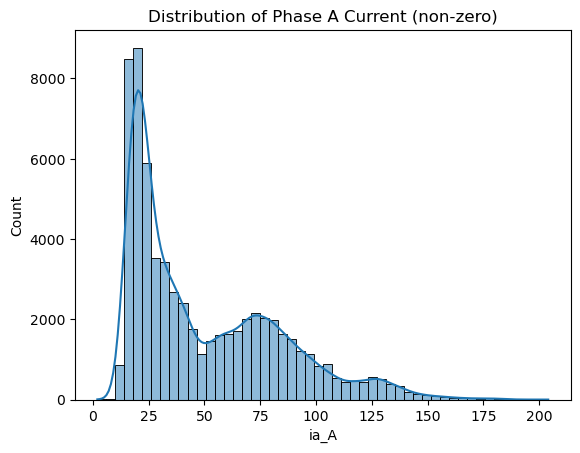

In [14]:
sns.histplot(df[df['ia_A'] > 0]['ia_A'], bins=50, kde=True)
plt.title("Distribution of Phase A Current (non-zero)")
plt.show()

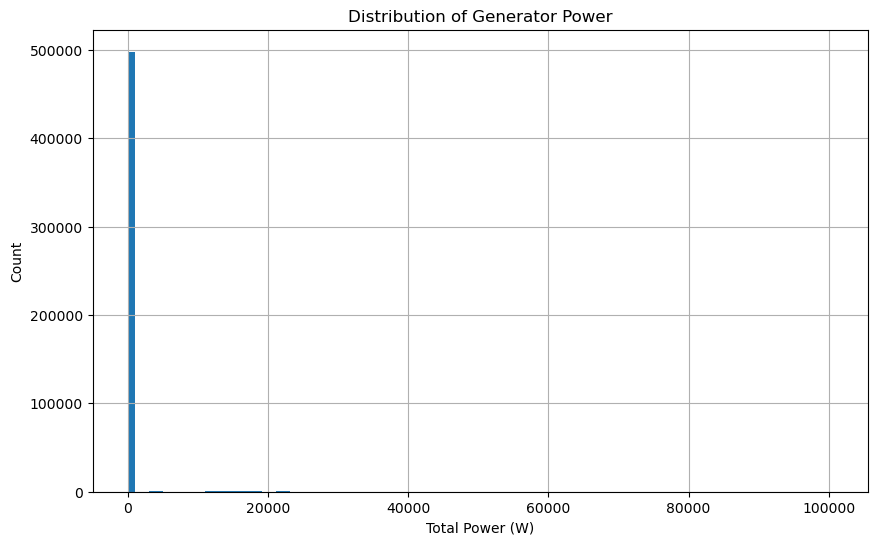

In [15]:


# Plot histogram of total power
plt.figure(figsize=(10,6))
df['ptot_W'].hist(bins=100)
plt.xlabel("Total Power (W)")
plt.ylabel("Count")
plt.title("Distribution of Generator Power")
plt.show()


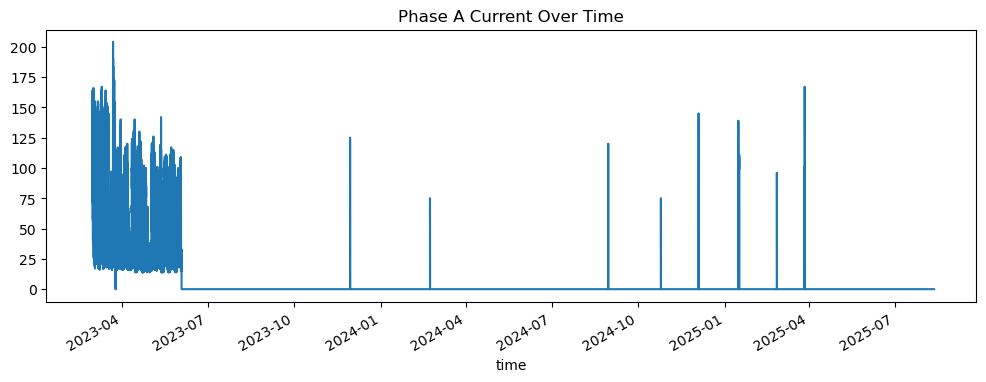

In [16]:
df.set_index('time')['ia_A'].plot(figsize=(12,4))
plt.title("Phase A Current Over Time")
plt.show()
# Plot Phase A current across time to visualize ON/OFF cycles and anomalies


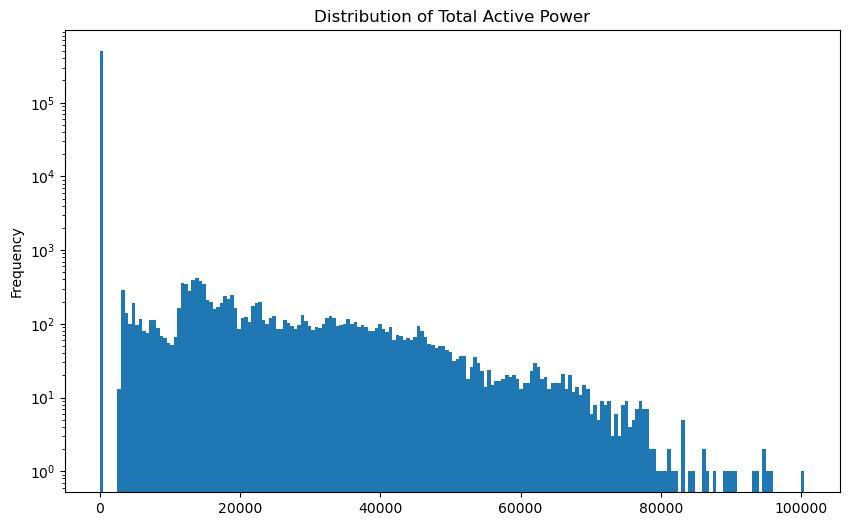

In [17]:
df['ptot_W'].plot(kind='hist', bins=200, logy=True, figsize=(10,6))
plt.title("Distribution of Total Active Power")
plt.show()
# Histogram of total power (log scale) – should reveal two modes (OFF near 0, ON at higher values)



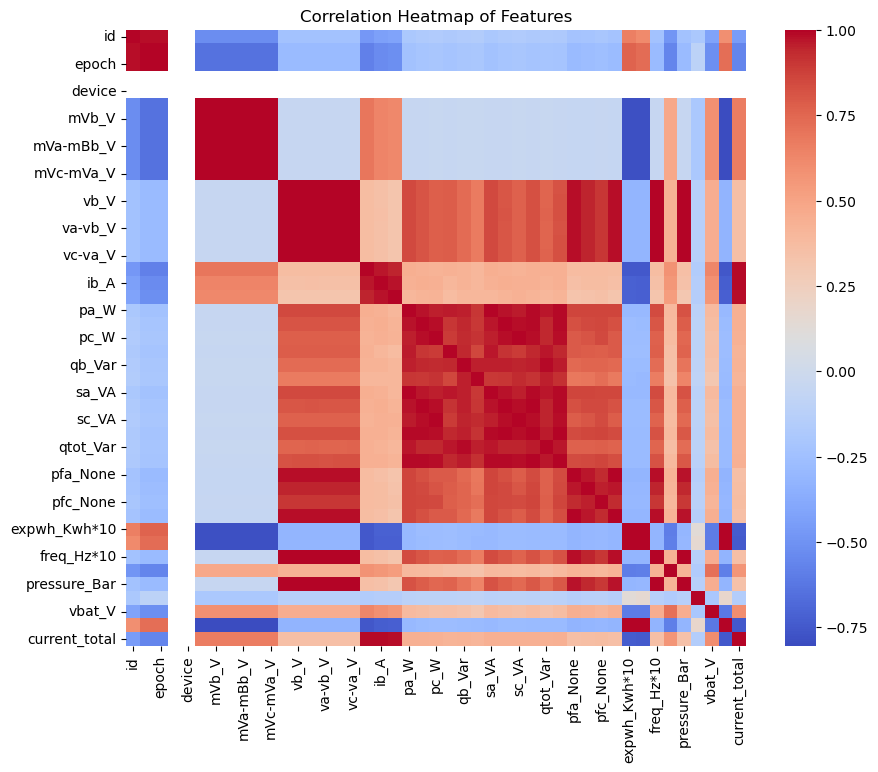

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Features")
plt.show()
# Heatmap of correlations between features – helps find redundant/related signals


In [19]:
from sklearn.mixture import GaussianMixture
import numpy as np

p = df['ptot_W'].clip(lower=0).fillna(0)
X = np.log1p(p).values.reshape(-1,1)
gmm = GaussianMixture(n_components=2, random_state=42).fit(X)
labels = gmm.predict(X)
means = gmm.means_.flatten()
on_cluster = np.argmax(means)
df['is_running_gmm'] = (labels == on_cluster).astype(int)
# cross-check with currents
df['any_current'] = df[['ia_A','ib_A','ic_A']].sum(axis=1) > 0.1
df['is_running'] = ((df['is_running_gmm']==1) | df['any_current']).astype(int)
#ON/OFF state detection using Gaussian Mixture Model on log(power).

C:\Users\tiaan\AppData\Local\Temp\ipykernel_38832\3383876476.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X[labels==0].flatten(), label="Cluster 0 (OFF?)", fill=True, color='blue')


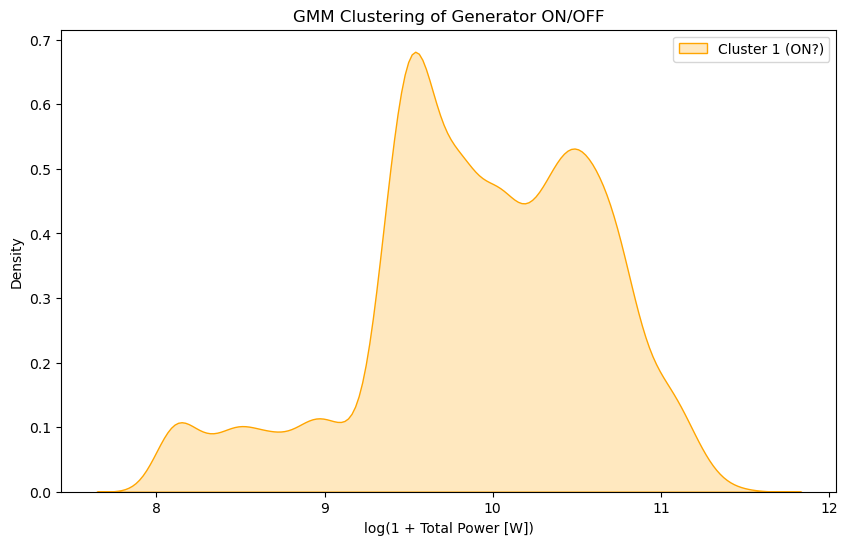

In [20]:

# Plot density instead of histogram
plt.figure(figsize=(10,6))
sns.kdeplot(X[labels==0].flatten(), label="Cluster 0 (OFF?)", fill=True, color='blue')
sns.kdeplot(X[labels==1].flatten(), label="Cluster 1 (ON?)", fill=True, color='orange')
plt.xlabel("log(1 + Total Power [W])")
plt.ylabel("Density")
plt.title("GMM Clustering of Generator ON/OFF")
plt.legend()
plt.show()

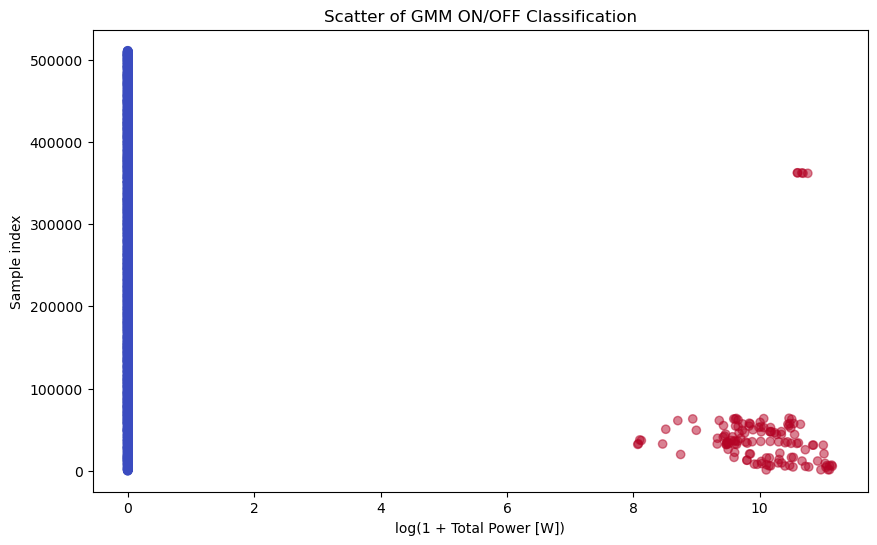

In [21]:
# Alternative: scatter plot (sample 5000 points)
sample = df.sample(5000, random_state=42)
plt.figure(figsize=(10,6))
plt.scatter(np.log1p(sample['ptot_W']), sample.index, c=sample['is_running_gmm'], cmap='coolwarm', alpha=0.5)
plt.xlabel("log(1 + Total Power [W])")
plt.ylabel("Sample index")
plt.title("Scatter of GMM ON/OFF Classification")
plt.show()

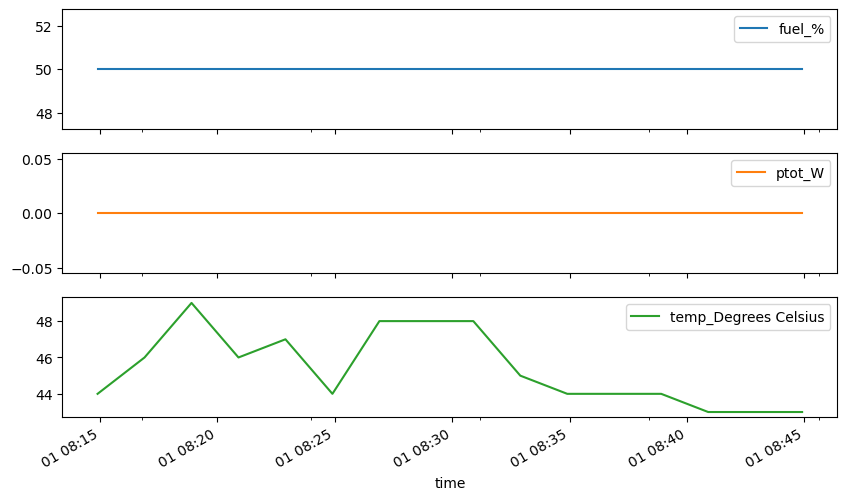

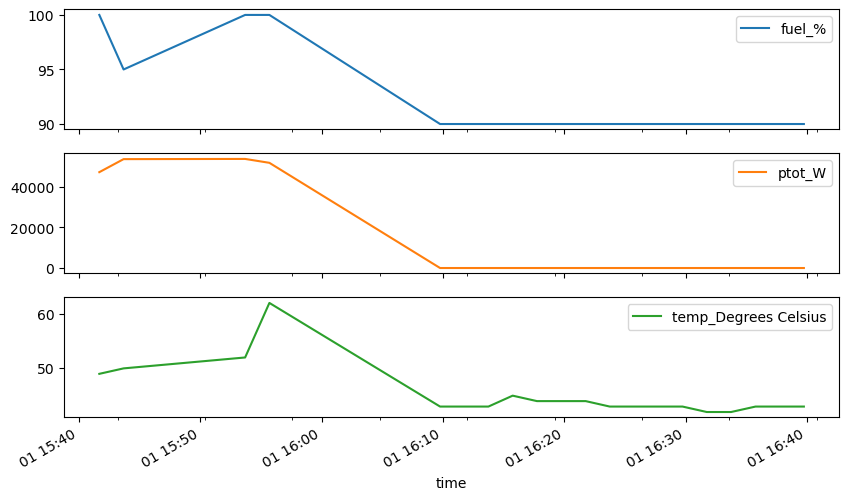

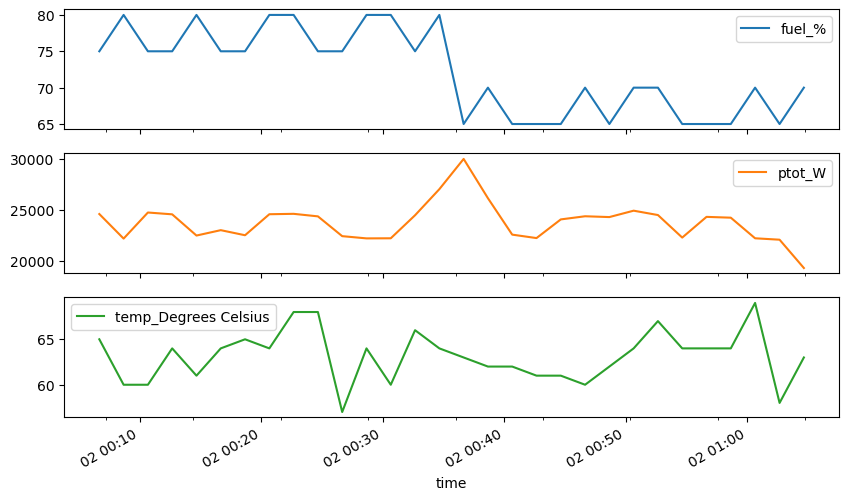

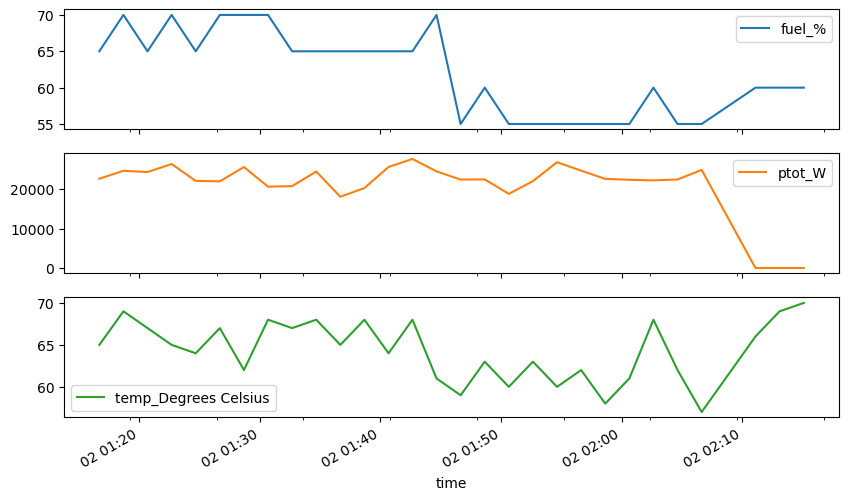

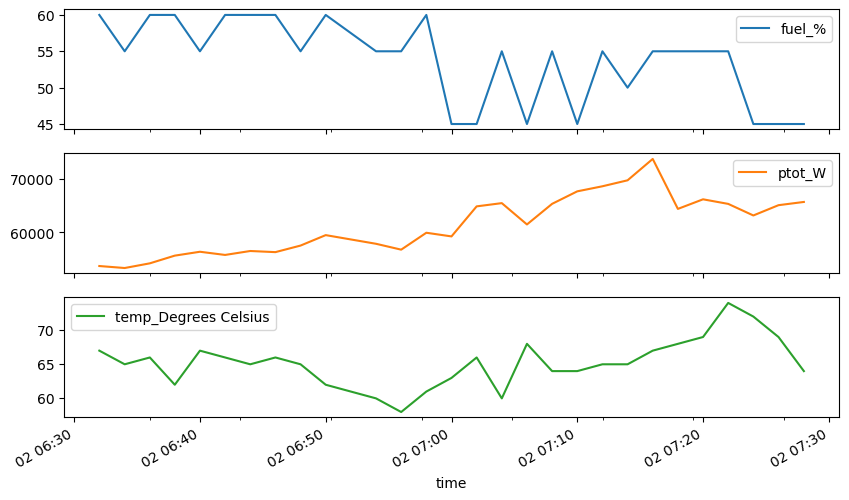

In [22]:
df = df.set_index('time')
df['fuel_pct_diff'] = df['fuel_%'].diff()
# flag drops bigger than 10% within 5 minutes (adjust threshold)
drop_mask = (df['fuel_pct_diff'] <= -10)
df[drop_mask].head()
# Plot a few drops to inspect
for t in df[drop_mask].index[:5]:
    window = df.loc[t - pd.Timedelta('30m') : t + pd.Timedelta('30m')]
    window[['fuel_%','ptot_W','temp_Degrees Celsius']].plot(subplots=True, figsize=(10,6))
    plt.show()
# Identify sudden fuel drops that may indicate sensor issues or refueling events


In [23]:
on = df[df['is_running']==1]
off = df[df['is_running']==0]
on[['temp_Degrees Celsius','ptot_W']].describe()
off[['temp_Degrees Celsius','ptot_W']].describe()
# Compare statistics of key sensors during ON vs OFF states to validate state detection

,temp_Degrees Celsius,ptot_W
count,445621.000000,445621.0
mean,24.322705,0.0
std,5.111956,0.0
min,0.000000,0.0
25%,20.000000,0.0
50%,23.000000,0.0
75%,28.000000,0.0
max,81.000000,0.0


In [24]:
corr = df.select_dtypes('number').corr().abs()
high_corr_pairs = [(i,j,corr.loc[i,j]) for i in corr.columns for j in corr.columns if i!=j and corr.loc[i,j]>0.95]
high_corr_pairs[:20]
# Identify highly correlated feature pairs (threshold adjustable)


[('id', 'epoch', 0.981661799053983),
 ('epoch', 'id', 0.981661799053983),
 ('mVa_V', 'mVb_V', 0.9999890817531754),
 ('mVa_V', 'mVc_v', 0.9999920413599618),
 ('mVa_V', 'mVa-mBb_V', 0.999997747137348),
 ('mVa_V', 'mVb-mVc_V', 0.999992861266549),
 ('mVa_V', 'mVc-mVa_V', 0.9999945607175075),
 ('mVb_V', 'mVa_V', 0.9999890817531754),
 ('mVb_V', 'mVc_v', 0.9999951565947865),
 ('mVb_V', 'mVa-mBb_V', 0.9999941243529462),
 ('mVb_V', 'mVb-mVc_V', 0.9999978676660197),
 ('mVb_V', 'mVc-mVa_V', 0.9999960920641002),
 ('mVc_v', 'mVa_V', 0.9999920413599618),
 ('mVc_v', 'mVb_V', 0.9999951565947865),
 ('mVc_v', 'mVa-mBb_V', 0.9999949110856253),
 ('mVc_v', 'mVb-mVc_V', 0.9999979167308765),
 ('mVc_v', 'mVc-mVa_V', 0.9999983464895896),
 ('mVa-mBb_V', 'mVa_V', 0.999997747137348),
 ('mVa-mBb_V', 'mVb_V', 0.9999941243529462),
 ('mVa-mBb_V', 'mVc_v', 0.9999949110856253)]